##### Impoport Libraries

In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import bipartite
import copy
from sklearn.preprocessing import StandardScaler
import scipy.special as special
import scipy.sparse as sp

import pickle
import os


import tensorflow as tf
#import tensorflow_addons as tfa
import keras

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, GRU, Input
from tensorflow.keras.optimizers import SGD, Adam


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, Dropout, Dense, LeakyReLU, GRU, Concatenate, Reshape, Softmax, Attention
from tensorflow.keras import activations
from tensorflow.keras.models import Model
#from keras.layers import LeakyReLU

from spektral.layers import  GCSConv, DiffusionConv, GATConv, ARMAConv, GCNConv

from tensorflow.keras.regularizers import l2

Using TensorFlow backend.


#####  Define Functions

In [2]:
def generate_graph_seq2seq_io_data(
        df, x_offsets, y_offsets, add_time_in_day=True, add_day_in_week=False, scaler=None
):
    """
    Generate samples from
    :param df:
    :param x_offsets:
    :param y_offsets:
    :param add_time_in_day:
    :param add_day_in_week:
    :param scaler:
    :return:
    # x: (epoch_size, input_length, num_nodes, input_dim)
    # y: (epoch_size, output_length, num_nodes, output_dim)
    """

    num_samples, num_nodes = df.shape
    data = np.expand_dims(df.values, axis=-1)
    data_list = [data]
    if add_time_in_day:
        time_ind = (df.index.values - df.index.values.astype("datetime64[D]")) / np.timedelta64(1, "D")
        time_in_day = np.tile(time_ind, [1, num_nodes, 1]).transpose((2, 1, 0))
        data_list.append(time_in_day)
    if add_day_in_week:
        day_in_week = np.zeros(shape=(num_samples, num_nodes, 7))
        day_in_week[np.arange(num_samples), :, df.index.dayofweek] = 1
        data_list.append(day_in_week)

    data = np.concatenate(data_list, axis=-1)
    # epoch_len = num_samples + min(x_offsets) - max(y_offsets)
    x, y = [], []
    # t is the index of the last observation.
    min_t = abs(min(x_offsets))
    max_t = abs(num_samples - abs(max(y_offsets)))  # Exclusive
    for t in range(min_t, max_t):
        x_t = data[t + x_offsets, ...]
        y_t = data[t + y_offsets, ...]
        x.append(x_t)
        y.append(y_t)
    x = np.stack(x, axis=0)
    y = np.stack(y, axis=0)
    return x, y



def plot_loss(dic):
    plt.figure(figsize=(12,5))
    #plt.subplot(1, 2, 1)
    plt.plot(dic['loss'], label='Training loss ')
    plt.plot(dic['val_loss'], label='Validation loss ')
    plt.legend(frameon=False)
    plt.title('train and validation loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    #plt.savefig('daily_loss.png', dpi = 400)
    plt.show()


    
def MSE(original, imputed):
    # calculate Mean Squared Error
    return np.square(original-imputed).mean()

def MPE(y_true, y_pred, threshold=0.1):
    v = np.copy(y_true)
    np.place(v, v==0, threshold)
    #v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return np.mean(diff, axis=-1).mean()

"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    m = np.mean(original) 
    denom = np.square(original - m)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq
"""
def R_squared(original, predicted):
    Differ = np.square(original-predicted)
    #m = np.mean(original) 
    denom = np.square(original)
    R_sq = 1 - ((Differ.sum())/denom.sum())
    return R_sq

def Get_performance(Y_true, Y_pred): 
    print ("R2 : ", np.round(R_squared(Y_true, Y_pred), 4))
    print ("MSE",  np.round(MSE(Y_true, Y_pred), 4))
    print ("MPE", np.round(MPE(Y_true, Y_pred), 4))
    
    return (np.round(R_squared(Y_true, Y_pred), 4), np.round(MSE(Y_true, Y_pred), 4), np.round(MPE(Y_true, Y_pred), 4)) 
        

def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))

def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))

def mape(y_true, y_pred, threshold=0.1):
    v = np.clip(np.abs(y_true), threshold, None)
    diff = np.abs((y_true - y_pred) / v)
    return 100.0 * np.mean(diff, axis=-1).mean()

def get_metrics(y, yp):
    return {
        "rmse": np.round(rmse(y, yp), 4),
        "mae": np.round(mae(y, yp), 4),
        "mape": np.round(mape(y, yp),4),
        #"MPE": np.round(MPE(y, yp), 4),
        #"R2": np.round(R_squared(y, yp),4)
        
    }


#if necessary

def top_k_filtering(logits, top_k=10):
    "Set values less than the k'th largest to 0."
    kth_largest = tf.math.top_k(logits, top_k)[0][-1]
    return tf.where(logits < kth_largest, 0, logits)

In [3]:
#Ger clean data and perform some simple cleaning

CRSP_data =  pd.read_pickle('data/daily_clear_ret.pickle')
print('Data Shape:', CRSP_data.shape)

CRSP_data.set_index(["datadate", "cusip"], inplace = True)
#CRSP_data.clip(lower=CRSP_data.quantile(0.01), upper=CRSP_data.quantile(0.01), axis=1, inplace = True)
CRSP_data.replace([np.inf, -np.inf], 0, inplace = True)
CRSP_data.fillna(0, inplace =True)
#CRSP_data.reset_index(inplace = True)
CRSP_data.sort_values(by =["datadate", "cusip"], inplace = True)
n_month = len(CRSP_data.groupby('datadate').size())
n_firms = len(CRSP_data.groupby('cusip').size())

In [8]:
#reshape the data in tensor format, and generate x and y variable

ret_data = CRSP_data[ "ret"].to_frame().pivot_table(values='ret', index='datadate', columns='cusip', aggfunc='mean')

#how many time lag I wanna use
n_lag = 36
#how many time period I wanna predict
n_forward = 1

x_offsets = np.sort(np.arange(-n_lag+1, 1, 1))
y_offsets = np.sort(np.arange(1, n_forward+1, 1))

x, y = generate_graph_seq2seq_io_data(
    ret_data,
    x_offsets=x_offsets,
    y_offsets=y_offsets,
    add_time_in_day=False,
    add_day_in_week=False,
    )

x = np.transpose(x, (0, 2, 1, 3))
y = np.transpose(y, (0, 2, 1, 3))

#reshape to made three dimensional tensor
x = x.reshape(x.shape[0],x.shape[1],x.shape[2] )
y = y.reshape(y.shape[0],y.shape[1],y.shape[2] )

#x = np.transpose(x, (0, 2, 1))
#y = np.transpose(y, (0, 2, 1))



x = x.astype('float32')
y = y.astype('float32')

In [12]:
#Do Standardization
#standardization
scaler = StandardScaler()
#scaler.fit(data)
data_stand = scaler.fit_transform(CRSP_data)
#data_stand = pd.DataFrame(data_stand, index=data.index,  columns=data.columns)  
features = data_stand.reshape(n_month, n_firms, CRSP_data.shape[1])
features = features[n_lag-1:-n_forward,:,:]

In [13]:
#create network
AdPos = np.empty([x.shape[0], x.shape[1], x.shape[1]])
AdNeg = np.empty([x.shape[0], x.shape[1], x.shape[1]])

for i in range(0, x.shape[0]):
    aa = np.corrcoef(x[i],rowvar=True)
    P_val =  np.abs((aa*np.sqrt(n_lag-2))/(np.sqrt(1-np.square(aa))))
    P_val  = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    ab = n_lag/2 - 1
    P_val = 2*special.btdtr(ab, ab, 0.5*(1 - abs(np.float64(aa))))
    P_val = np.nan_to_num(P_val, nan=0.0, posinf=0, neginf=0)
    P_val  = np.where(P_val>0.05, 0, 1)
    
    Adjac = aa*P_val
    #adj_matrix[i] = P_val 
    
    AdPos[i] =  np.where(Adjac > 0,1,0 )
    AdNeg[i] =  np.where(Adjac < 0,1,0 )

/home/ajim/.local/lib/python3.5/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [14]:

#split data into train, validation and test set
x_train = x[:1258,:,:]
y_train = y[:1258,:,:]



x_val = x[1258:1761,:,:]
y_val = y[1258:1761,:,:]


x_test = x[1761:,:,:]
y_test = y[1761:,:,:]


features_train  = features[:1258,:,:]
features_val  =   features[1258:1761,:,:]
features_test  =  features[1761:,:,:]




adj_pos_train = AdPos[:1258,:,:]
adj_pos_val = AdPos[1258:1761,:,:]
adj_pos_test = AdPos[1761:,:,:]

adj_neg_train = AdNeg[:1258,:,:]
adj_neg_val = AdNeg[1258:1761,:,:]
adj_neg_test = AdNeg[1761:,:,:]



In [15]:
# Set Hyperpaprameters
tf.keras.backend.clear_session()
tf.autograph.set_verbosity(0)

learning_rate = 0.0001
batch_size =24
epochs = 100
seed = 42
verbose = 1

In [17]:
## Define Model

inputs_ret = Input(shape=(x.shape[1], x.shape[2], ))
inputs_feat = Input(shape=(features.shape[1], features.shape[2], ))
inputs_adj_pos = Input(shape=(features.shape[1],features.shape[1], ))
inputs_adj_neg = Input(shape=(features.shape[1],features.shape[1], ))
#inputs_3 = Input(shape=(data_shape[1],k, ))

GAT_output_P, Att_weights_P =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=True, 
                                   activation='relu', use_bias=False)([inputs_ret, inputs_adj_pos])
Att_weights_P = tf.math.reduce_mean(Att_weights_P, axis=2)

GAT_output_P_2 =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=False, 
                        activation='relu', use_bias=True)([inputs_feat, inputs_adj_pos])

diff_out = DiffusionConv(16, K=6, activation='tanh')([inputs_feat, Att_weights_P])
#diff_out = ARMAConv(16, order=2, iterations=1, share_weights=False, gcn_activation='relu', dropout_rate=0.0, activation=None, use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros', kernel_regularizer=None, bias_regularizer=None, activity_regularizer=None, kernel_constraint=None, bias_constraint=None)


con_out_P_2 = Concatenate(axis=-1)([diff_out, GAT_output_P_2, GAT_output_P])
dense_P = Dense(8, activation='relu')(con_out_P_2)



GAT_output_N, Att_weights_N =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=True, 
                                   activation='relu', use_bias=False)([inputs_ret, inputs_adj_neg])
Att_weights_N = tf.math.reduce_mean(Att_weights_N, axis=2)

#con_out_N = Concatenate(axis=-1)([GAT_output_N, GAT_output_NF])

GAT_output_N_2 =  GATConv(16, attn_heads=4, concat_heads=True, dropout_rate=0.3, return_attn_coef=False, 
                        activation='relu', use_bias=True)([inputs_feat, inputs_adj_neg])

diff_out_N = DiffusionConv(16, K=6, activation='tanh')([inputs_feat, Att_weights_N])
con_out_N_2 = Concatenate(axis=-1)([diff_out_N, GAT_output_N_2, GAT_output_N])
dense_N = Dense(8, activation='relu')(con_out_N_2)


con_out = Concatenate(axis=-1)([dense_P, dense_N])
dense_out = Dense(8, activation='linear')(con_out)
dense_out = Dropout(0.2)(dense_out)
outputs = Dense(1)(dense_out)




In [18]:

model = Model(inputs=[inputs_ret, inputs_feat, inputs_adj_pos, inputs_adj_neg], outputs=outputs)
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=["mae", "mape"])
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 369, 36)]    0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 369, 369)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 369, 369)]   0                                            
__________________________________________________________________________________________________
gat_conv (GATConv)              ((None, 369, 64), (N 2432        input_1[0][0]                    
                                                                 input_3[0][0]         

In [19]:
hists = model.fit(x= [x_train, features_train, adj_pos_train, adj_neg_train],
                  y= y_train, verbose=verbose, epochs=500,
                  batch_size=batch_size, #validation_split=0.1, 
                  validation_data=([x_val, features_val, adj_pos_val, adj_neg_val], y_val),
                  callbacks=[EarlyStopping(#monitor="val_mean_absolute_error", 
                      monitor="val_loss", patience=20, restore_best_weights=True)], )

Epoch 1/500
53/53 [==============================] - 75s 1s/step - loss: 1.0038 - mape: 6614166.0000 - mae: 0.8529 - val_loss: 0.2034 - val_mae: 0.2595 - val_mape: 1796886.1250
Epoch 2/500
53/53 [==============================] - 73s 1s/step - loss: 0.4618 - mape: 4233501.5000 - mae: 0.5655 - val_loss: 0.1055 - val_mae: 0.1927 - val_mape: 1344367.5000
Epoch 3/500
53/53 [==============================] - 71s 1s/step - loss: 0.2118 - mape: 2764622.7500 - mae: 0.3648 - val_loss: 0.0555 - val_mae: 0.1501 - val_mape: 1054183.7500
Epoch 4/500
53/53 [==============================] - 72s 1s/step - loss: 0.1132 - mape: 1978796.1250 - mae: 0.2526 - val_loss: 0.0313 - val_mae: 0.1135 - val_mape: 808113.7500
Epoch 5/500
53/53 [==============================] - 73s 1s/step - loss: 0.0702 - mape: 1530082.2500 - mae: 0.1976 - val_loss: 0.0200 - val_mae: 0.0871 - val_mape: 624059.1875
Epoch 6/500
53/53 [==============================] - 73s 1s/step - loss: 0.0527 - mape: 1333905.3750 - mae: 0.1696 - 

53/53 [==============================] - 49s 923ms/step - loss: 9.9715e-04 - mape: 125207.5078 - mae: 0.0210 - val_loss: 4.3491e-04 - val_mae: 0.0131 - val_mape: 48104.9648
Epoch 93/500
53/53 [==============================] - 49s 923ms/step - loss: 9.5348e-04 - mape: 123320.2188 - mae: 0.0208 - val_loss: 4.3112e-04 - val_mae: 0.0130 - val_mape: 47493.1641
Epoch 94/500
53/53 [==============================] - 49s 918ms/step - loss: 9.4118e-04 - mape: 121384.0234 - mae: 0.0206 - val_loss: 4.2855e-04 - val_mae: 0.0130 - val_mape: 47150.8672
Epoch 95/500
53/53 [==============================] - 49s 918ms/step - loss: 9.2021e-04 - mape: 122842.2188 - mae: 0.0204 - val_loss: 4.2670e-04 - val_mae: 0.0130 - val_mape: 47300.0430
Epoch 96/500
53/53 [==============================] - 49s 918ms/step - loss: 9.1108e-04 - mape: 119030.7891 - mae: 0.0202 - val_loss: 4.2468e-04 - val_mae: 0.0129 - val_mape: 46299.5000
Epoch 97/500
53/53 [==============================] - 49s 927ms/step - loss: 9.0178

53/53 [==============================] - 48s 900ms/step - loss: 4.3085e-04 - mape: 41908.3672 - mae: 0.0124 - val_loss: 3.1209e-04 - val_mae: 0.0108 - val_mape: 25451.7012
Epoch 181/500
53/53 [==============================] - 48s 905ms/step - loss: 4.2857e-04 - mape: 41380.4336 - mae: 0.0124 - val_loss: 3.1206e-04 - val_mae: 0.0108 - val_mape: 27145.0293
Epoch 182/500
53/53 [==============================] - 48s 912ms/step - loss: 4.2623e-04 - mape: 40780.8203 - mae: 0.0123 - val_loss: 3.1480e-04 - val_mae: 0.0110 - val_mape: 28999.0410
Epoch 183/500
53/53 [==============================] - 49s 920ms/step - loss: 4.2536e-04 - mape: 39081.0508 - mae: 0.0123 - val_loss: 3.1311e-04 - val_mae: 0.0109 - val_mape: 28036.6465
Epoch 184/500
53/53 [==============================] - 49s 921ms/step - loss: 4.2354e-04 - mape: 40028.9453 - mae: 0.0122 - val_loss: 3.1222e-04 - val_mae: 0.0109 - val_mape: 27563.7871
Epoch 185/500
53/53 [==============================] - 49s 925ms/step - loss: 4.2734

53/53 [==============================] - 49s 921ms/step - loss: 3.6896e-04 - mape: 26321.3359 - mae: 0.0108 - val_loss: 3.0232e-04 - val_mae: 0.0108 - val_mape: 27735.3672
Epoch 269/500
53/53 [==============================] - 48s 915ms/step - loss: 3.7121e-04 - mape: 27574.9668 - mae: 0.0109 - val_loss: 3.0139e-04 - val_mae: 0.0108 - val_mape: 26377.1230
Epoch 270/500
53/53 [==============================] - 49s 921ms/step - loss: 3.6743e-04 - mape: 26668.7461 - mae: 0.0108 - val_loss: 2.9794e-04 - val_mae: 0.0106 - val_mape: 23144.5918
Epoch 271/500
53/53 [==============================] - 49s 919ms/step - loss: 3.6869e-04 - mape: 27132.9941 - mae: 0.0108 - val_loss: 3.0159e-04 - val_mae: 0.0108 - val_mape: 27291.2793
Epoch 272/500
53/53 [==============================] - 48s 914ms/step - loss: 3.6847e-04 - mape: 27709.8105 - mae: 0.0108 - val_loss: 2.9860e-04 - val_mae: 0.0106 - val_mape: 23217.1875
Epoch 273/500
53/53 [==============================] - 48s 914ms/step - loss: 3.6952

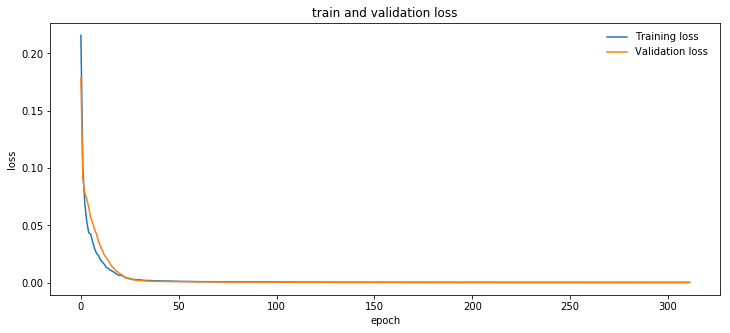

In [151]:
plot_loss(hists.history)

In [152]:
train_predicted = model.predict([x_train, features_train, adj_pos_train, adj_neg_train])
get_metrics(y_train.flatten(), train_predicted.flatten())

{'mae': 0.01, 'mape': 9.7991, 'rmse': 0.0184}

In [153]:
val_predicted = model.predict([x_val, features_val, adj_pos_val, adj_neg_val])
get_metrics(y_val.flatten(), val_predicted.flatten())

{'mae': 0.0109, 'mape': 10.7828, 'rmse': 0.0175}

In [155]:
test_predicted = model.predict([x_test, features_test, adj_pos_test, adj_neg_test ])
get_metrics(y_test.flatten(), test_predicted.flatten())

{'mae': 0.017, 'mape': 16.583, 'rmse': 0.027}

In [156]:

y_test_2  = y_test.reshape(y_test.shape[0],y_test.shape[1])
pred_test_2  = test_predicted.reshape(test_predicted.shape[0],test_predicted.shape[1])

In [157]:
k = int(y_test_2.shape[1]*0.10)
short_port = np.empty([y_test_2.shape[0], k])
long_port = np.empty([y_test_2.shape[0], k])

for i in range(0, len(y_test_2)):
    b_f = pred_test_2[i].argsort()[:k]
    t_f = pred_test_2[i].argsort()[-k:]
    
    short_port[i] = y_test_2[i][b_f]
    long_port[i] = y_test_2[i][t_f]
    

/home/ajim/.local/lib/python3.5/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


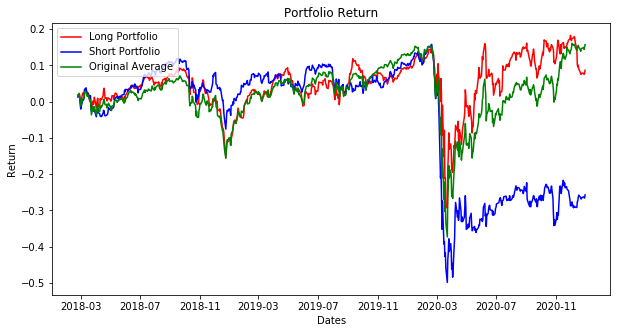

In [158]:
plt.figure(figsize=(10,5))
plt.title("Portfolio Return")  
plt.xlabel("Dates")  
plt.ylabel("Return")
plt.plot(ret_data.index[-long_port.shape[0]:],long_port.mean(axis=1).cumsum(), color ="red", label="Long Portfolio")
plt.plot(ret_data.index[-long_port.shape[0]:],short_port.mean(axis=1).cumsum(), color ="blue", label="Short Portfolio")
plt.plot(ret_data.index[-long_port.shape[0]:], y_test_2.mean(axis=1).cumsum(), color ="green", label="Original Average")
plt.legend(loc="upper left")
plt.show()

In [160]:
Just_ret_res = pd.DataFrame(pred_test_2, index = ret_data.index[-long_port.shape[0]:], columns =  ret_data.columns)

In [162]:
#Just_ret_res.to_pickle('/largedisks/ajim/KDD21_data/Daily/Just_ret_result.pickle')

In [78]:
#ret_data.to_pickle('/largedisks/ajim/KDD21_data/Daily/Original_ret.pickle')

####  Create Symmetric Adj Matrix

In [20]:
import networkx as nx
import copy
from datetime import datetime
import random

import pylab as plt
from sklearn.preprocessing import normalize

from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds, eigsh
from scipy import sparse
from numpy import linalg as LA


from scipy.spatial import distance_matrix
from sklearn.metrics.pairwise import cosine_distances
from sklearn.metrics import pairwise_distances

In [21]:
def calculate_corr(Data):
    k = Data.corr()
    k.dropna(axis=0, how='all', inplace = True)
    k.dropna(axis=1, how='all', inplace = True)
    return k


#Some Definations
'''
find the arithmetic average as typical behavior
'''
def average_typical_behavior(context_vecs):
    avg = np.mean(context_vecs, axis=0)
    return avg

'''
find the left singular vector of the activity matrix
'''
def principal_vec_typical_behavior(context_vecs):
    activity_matrix = context_vecs.T
    u, s, vh = np.linalg.svd(activity_matrix, full_matrices=False)
    # print ("shape of each vector is: " + str(context_vecs[0].shape))
    # print ("shape of typical vector is: " + str(u[:,0].shape))
    return u[:,0]


'''
compute the z score as defined by Akoglu and Faloutsos in EVENT DETECTION IN TIME SERIES OF MOBILE COMMUNICATION GRAPHS
Z = 1-u^(T)r
'''
def compute_Z_score(cur_vec, typical_vec):
    # print (cur_vec[0:6])
    # print (typical_vec[0:6])
    cosine_similarity = abs(np.dot(cur_vec, typical_vec) / LA.norm(cur_vec) / LA.norm(typical_vec))
    z = (1 - cosine_similarity)
    return z


def rank_outliers(x, window=5, initial_period=10):
    #percent_ranked = 0.18
    x = np.asarray(x)
    mv_std = []

    for i in range(0, initial_period):
        mv_std.append(0)

    for i in range(initial_period,len(x)):
        #compute moving average until this point
        avg = np.mean(x[i-window:i])
        std = np.std(x[i-window:i])
        if (std == 0):
            std = 1
        mv_std.append(abs(x[i]-avg) / std)
        
    mv_std = np.asarray(mv_std)
    outlier_ranks = mv_std.argsort()

    return outlier_ranks



def difference_score(z_scores):
    z = []
    for i in range(len(z_scores)):
        if (i==0):
            z.append(z_scores[0])
        else:
            z.append(z_scores[i] - z_scores[i-1])
    return z


def set_non_negative(z_scores):
    for i in range(len(z_scores)):
        if (z_scores[i] < 0):
            z_scores[i] = 0
    return z_scores



def change_detection_two_windows(spectrums, principal=True, percent_ranked=0.05, window1=5, window2=15, initial_window=20, difference=True):

    z_scores = []
    z_shorts = []
    z_longs = []
    counter = 0
    for i in range(0, initial_window):
        z_shorts.append(0)
        z_longs.append(0)
        z_scores.append(0)      
    
    #compute the z score for each signature vector after initial window
    #1. find typical behavior
    #2. compute anomaly score
    for i in range(initial_window, len(spectrums)):

        #1. compute short term window first
        if (principal):
            typical_vec = principal_vec_typical_behavior(spectrums[i-window1:i])
        else:
            typical_vec = average_typical_behavior(spectrums[i-window1:i])
        cur_vec = spectrums[i]
        z_short = compute_Z_score(cur_vec, typical_vec)
        z_shorts.append(z_short)


        #2. compute long term window
        if (principal):
            typical_vec = principal_vec_typical_behavior(spectrums[i-window2:i])
        else:
            typical_vec = average_typical_behavior(spectrums[i-window2:i])
        cur_vec = spectrums[i]
        z_long = compute_Z_score(cur_vec, typical_vec)
        z_longs.append(z_long)

    #check the change in z score instead
    if (difference):
        z_shorts = difference_score(z_shorts)
        z_longs = difference_score(z_longs)

    z_scores = [0] * len(z_shorts)
    for i in range(len(z_scores)):
        z_scores[i] = max(z_shorts[i], z_longs[i])

    z_scores = np.asarray(z_scores)
    num_ranked = int(round(len(z_scores) * percent_ranked))
    outliers = z_scores.argsort()[-num_ranked:][::-1]
    outliers.sort()
    return (z_shorts,z_longs,z_scores,outliers)





In [101]:
inter_output_model = Model(model.input, model.get_layer('tf_op_layer_Mean').output )
a_pos = inter_output_model.predict([[x, features, AdPos, AdNeg]])

In [106]:
inter_output_model = Model(model.input, model.get_layer('tf_op_layer_Mean_1').output )
a_neg = inter_output_model.predict([[x, features, AdPos, AdNeg]])

#### Perform Spectrum Analyis on the learned embeddin

In [26]:
from scipy.sparse.linalg import eigsh, ArpackNoConvergence

In [27]:
num_eigen = 10


G_times = np.empty_like(a_pos)

Temporal_eigenvalues = []
activity_vecs = []  #eigenvector of the largest eigenvalue


for i in range(0, len(a_pos)):

    CR = np.dot(a_pos[i], np.transpose(a_pos[i]))
    np.fill_diagonal(CR, 0)
    
    G_times[i] = CR
    
    D = np.diag(abs(CR).sum(axis=1))
    L = D - CR
    
    
    
    try:
        u, s, vh = svds(L, k=num_eigen, which= 'SM')
    except ArpackNoConvergence as e:
        print(e)
        ls = e.eigenvalues
        s = np.zeros(num_eigen)
        for j in range(0, len(ls)):
            s[-(j)] = ls[(-j)]
        
        
        #v = e.eigenvectors
        #print(w.shape, v.shape)
    
    #u, s, vh = svds(L, k=num_eigen, which= 'SM')
    # u, s, vh = randomized_svd(L, num_eigen)
    #vals = s
    vals = np.nan_to_num(s, 0)
    
    Temporal_eigenvalues.append(np.asarray(vals))
    
    print(i)

/usr/local/lib/python3.5/dist-packages/scipy/sparse/linalg/eigen/arpack/arpack.py:1849: RuntimeWarning: invalid value encountered in sqrt
  s = np.sqrt(eigvals)


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065


In [29]:
spectrums = np.asarray(Temporal_eigenvalues)
spectrums = spectrums.real
spectrums = spectrums.reshape((len(Temporal_eigenvalues),-1))
spectrums = np.nan_to_num(spectrums)
spectrums = normalize(spectrums, norm='l2')

In [72]:
spect = pd.DataFrame(spectrums, index = ret_data.index[36:])
spect.sort_index(inplace = True)

In [60]:
spectrums

array([[0.00000000e+00, 1.22485980e-01, 2.35232562e-01, ...,
        3.94412309e-01, 4.00166392e-01, 4.14271325e-01],
       [0.00000000e+00, 1.17596664e-01, 2.64865905e-01, ...,
        3.82778853e-01, 3.92219752e-01, 4.06291395e-01],
       [0.00000000e+00, 9.42520648e-02, 1.70913175e-01, ...,
        3.91882241e-01, 4.30466980e-01, 4.47259963e-01],
       ...,
       [0.00000000e+00, 0.00000000e+00, 1.06053226e-01, ...,
        4.14354473e-01, 4.31099176e-01, 4.33784664e-01],
       [0.00000000e+00, 0.00000000e+00, 9.00362954e-02, ...,
        4.16040987e-01, 4.36998546e-01, 4.68926042e-01],
       [0.00000000e+00, 1.89802464e-04, 8.44013095e-02, ...,
        3.96002680e-01, 4.38925236e-01, 4.50441390e-01]], dtype=float32)

In [54]:
percent_ranked=0.01
window1 = 42
window2 = 126
initial_window = 126


In [55]:
(z_shorts,z_longs,z_scores,anomalies) = change_detection_two_windows(spectrums, principal=True, 
                                                                     percent_ranked=percent_ranked, window1=window1, window2=window2, initial_window=initial_window, difference=True)
print ("found anomalous time stamps are")
print (anomalies)
events = anomalies

found anomalous time stamps are
[ 126  166  207  210  269  286  289  659  667 1004 1143 1184 1193 1194
 1617 1622 1741 1875 2023 2052 2168 2177 2202 2333 2338]


In [95]:
month_list = [d.strftime('%d-%m-%Y') for d in  ret_data.index]
month_list = month_list[24:]

plotting anomaly scores complete


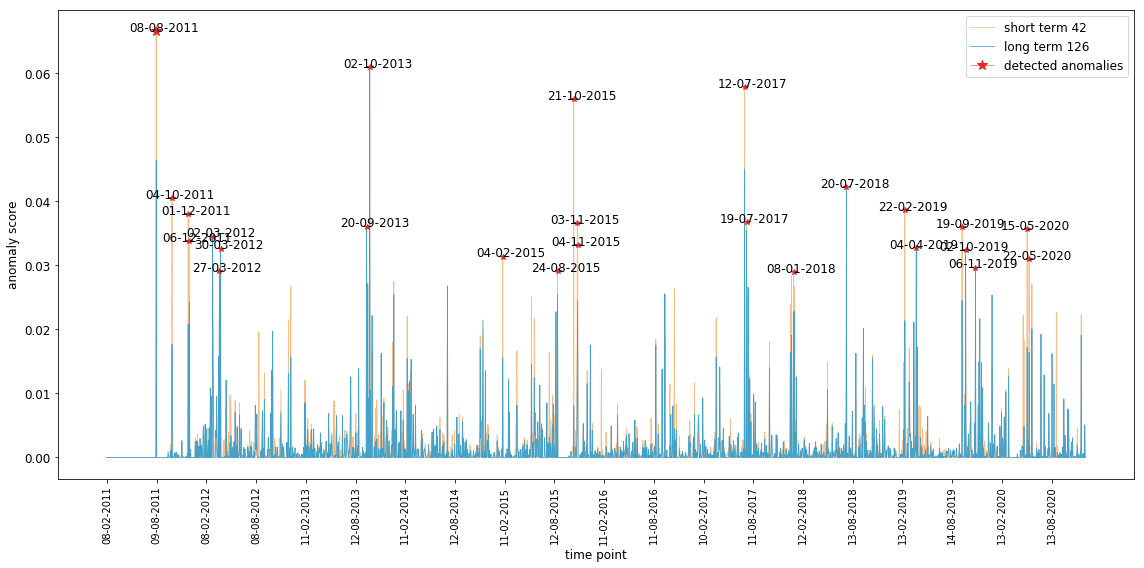

In [98]:
#plot_anomaly with short and long term window



scores = []
scores.append(z_shorts)
scores.append(z_longs)
score_labels = ["short term " + str(window1), "long term " + str(window2)]
#plot_anomaly_score("USLegis", fname, scores, score_labels, events)

for k in range(len(scores)):
        scores[k] = set_non_negative(scores[k])

max_time = len(scores[0])
t = list(range(0, max_time))


plt.rcParams.update({'figure.autolayout': True})
plt.rc('xtick')
plt.rc('ytick')
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 1, 1)
colors = ['#fdbb84', '#43a2ca', '#bc5090', '#e5f5e0','#fa9fb5','#c51b8a']
for i in range(len(scores)):
    ax.plot(t, scores[i], color=colors[i], ls='solid', lw=0.8, label=score_labels[i])

 
for event in events:
    max_score = 0
    for i in range(len(scores)):
        if scores[i][event] > max_score:
            max_score = scores[i][event]
            
            
    plt.annotate(month_list[event],      
                 #str(event), # this is the text
                 (event, max_score), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(8,0), # distance from text to points (x,y)
                 ha='center',
                 fontsize=12) # horizontal alignment can be left, right or center
    
addLegend = True

for event in events:
    #plt.axvline(x=event,color='k', linestyle="--", linewidth=0.5)
    max_score = 0
    for i in range(len(scores)):
        if scores[i][event] > max_score:
            max_score = scores[i][event]
    if (addLegend):
        ax.plot( event, max_score, marker="*", markersize=10, color='#de2d26', ls='solid', lw=0.5, label="detected anomalies")
        addLegend=False
    else:
        ax.plot( event, max_score, marker="*", color='#de2d26', ls='solid', lw=0.5)

        


        

#plt.xticks(t, labels, fontsize=8, rotation=90)
#ax.set_xlabel('year', fontsize=12)

ax.set_xlabel('time point', fontsize=12)
#plt.xticks(fontsize=12)
x_index= np.arange(1, len(month_list), step=126)
plt.xticks(x_index, np.asarray(month_list)[x_index] ,rotation=90)#, fontsize=12)
plt.yticks(fontsize=12)
ax.set_ylabel('anomaly score', fontsize=12)
plt.legend(fontsize=12)
plt.savefig('anomaly_graph_daily.png',  dpi=700)

print ("plotting anomaly scores complete")